## Import Libraries

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import keras_tuner as kt
from keras.optimizers import Adam

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

# Ignore specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Current working directory
current_dir = os.getcwd()

# Define BASE_DIR
BASE_DIR = os.path.abspath(os.path.join(current_dir, '..'))

BASE_DIR

'd:\\Gravitar\\Crop Recommendation System'

## Load Data

In [5]:
data_path = Path(os.path.join(BASE_DIR, "data", "crop_data.csv"))
df = pd.read_csv(data_path)

In [6]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


## Data Preprocessing

In [8]:
df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [9]:
df.size

17600

In [10]:
df.shape

(2200, 8)

In [11]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [12]:
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [13]:
df.label.unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [14]:
df.dtypes

N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

In [15]:
df.label.value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

In [16]:
# Encoding the target variable
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [71]:
joblib.dump(label_encoder, "./models/label_encoder.joblib")

['./models/label_encoder.joblib']

In [17]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label,label_encoded
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,20


In [18]:
df['label_encoded'].unique()

array([20, 11,  3,  9, 18, 13, 14,  2, 10, 19,  1, 12,  7, 21, 15,  0, 16,
       17,  4,  6,  8,  5])

In [19]:
X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = df['label_encoded']

## Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "./models/scaler_object.joblib")

['./models/scaler_object.joblib']

## Exploratory Data Analysis

In [23]:
plots_dir = "./plots_dir"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

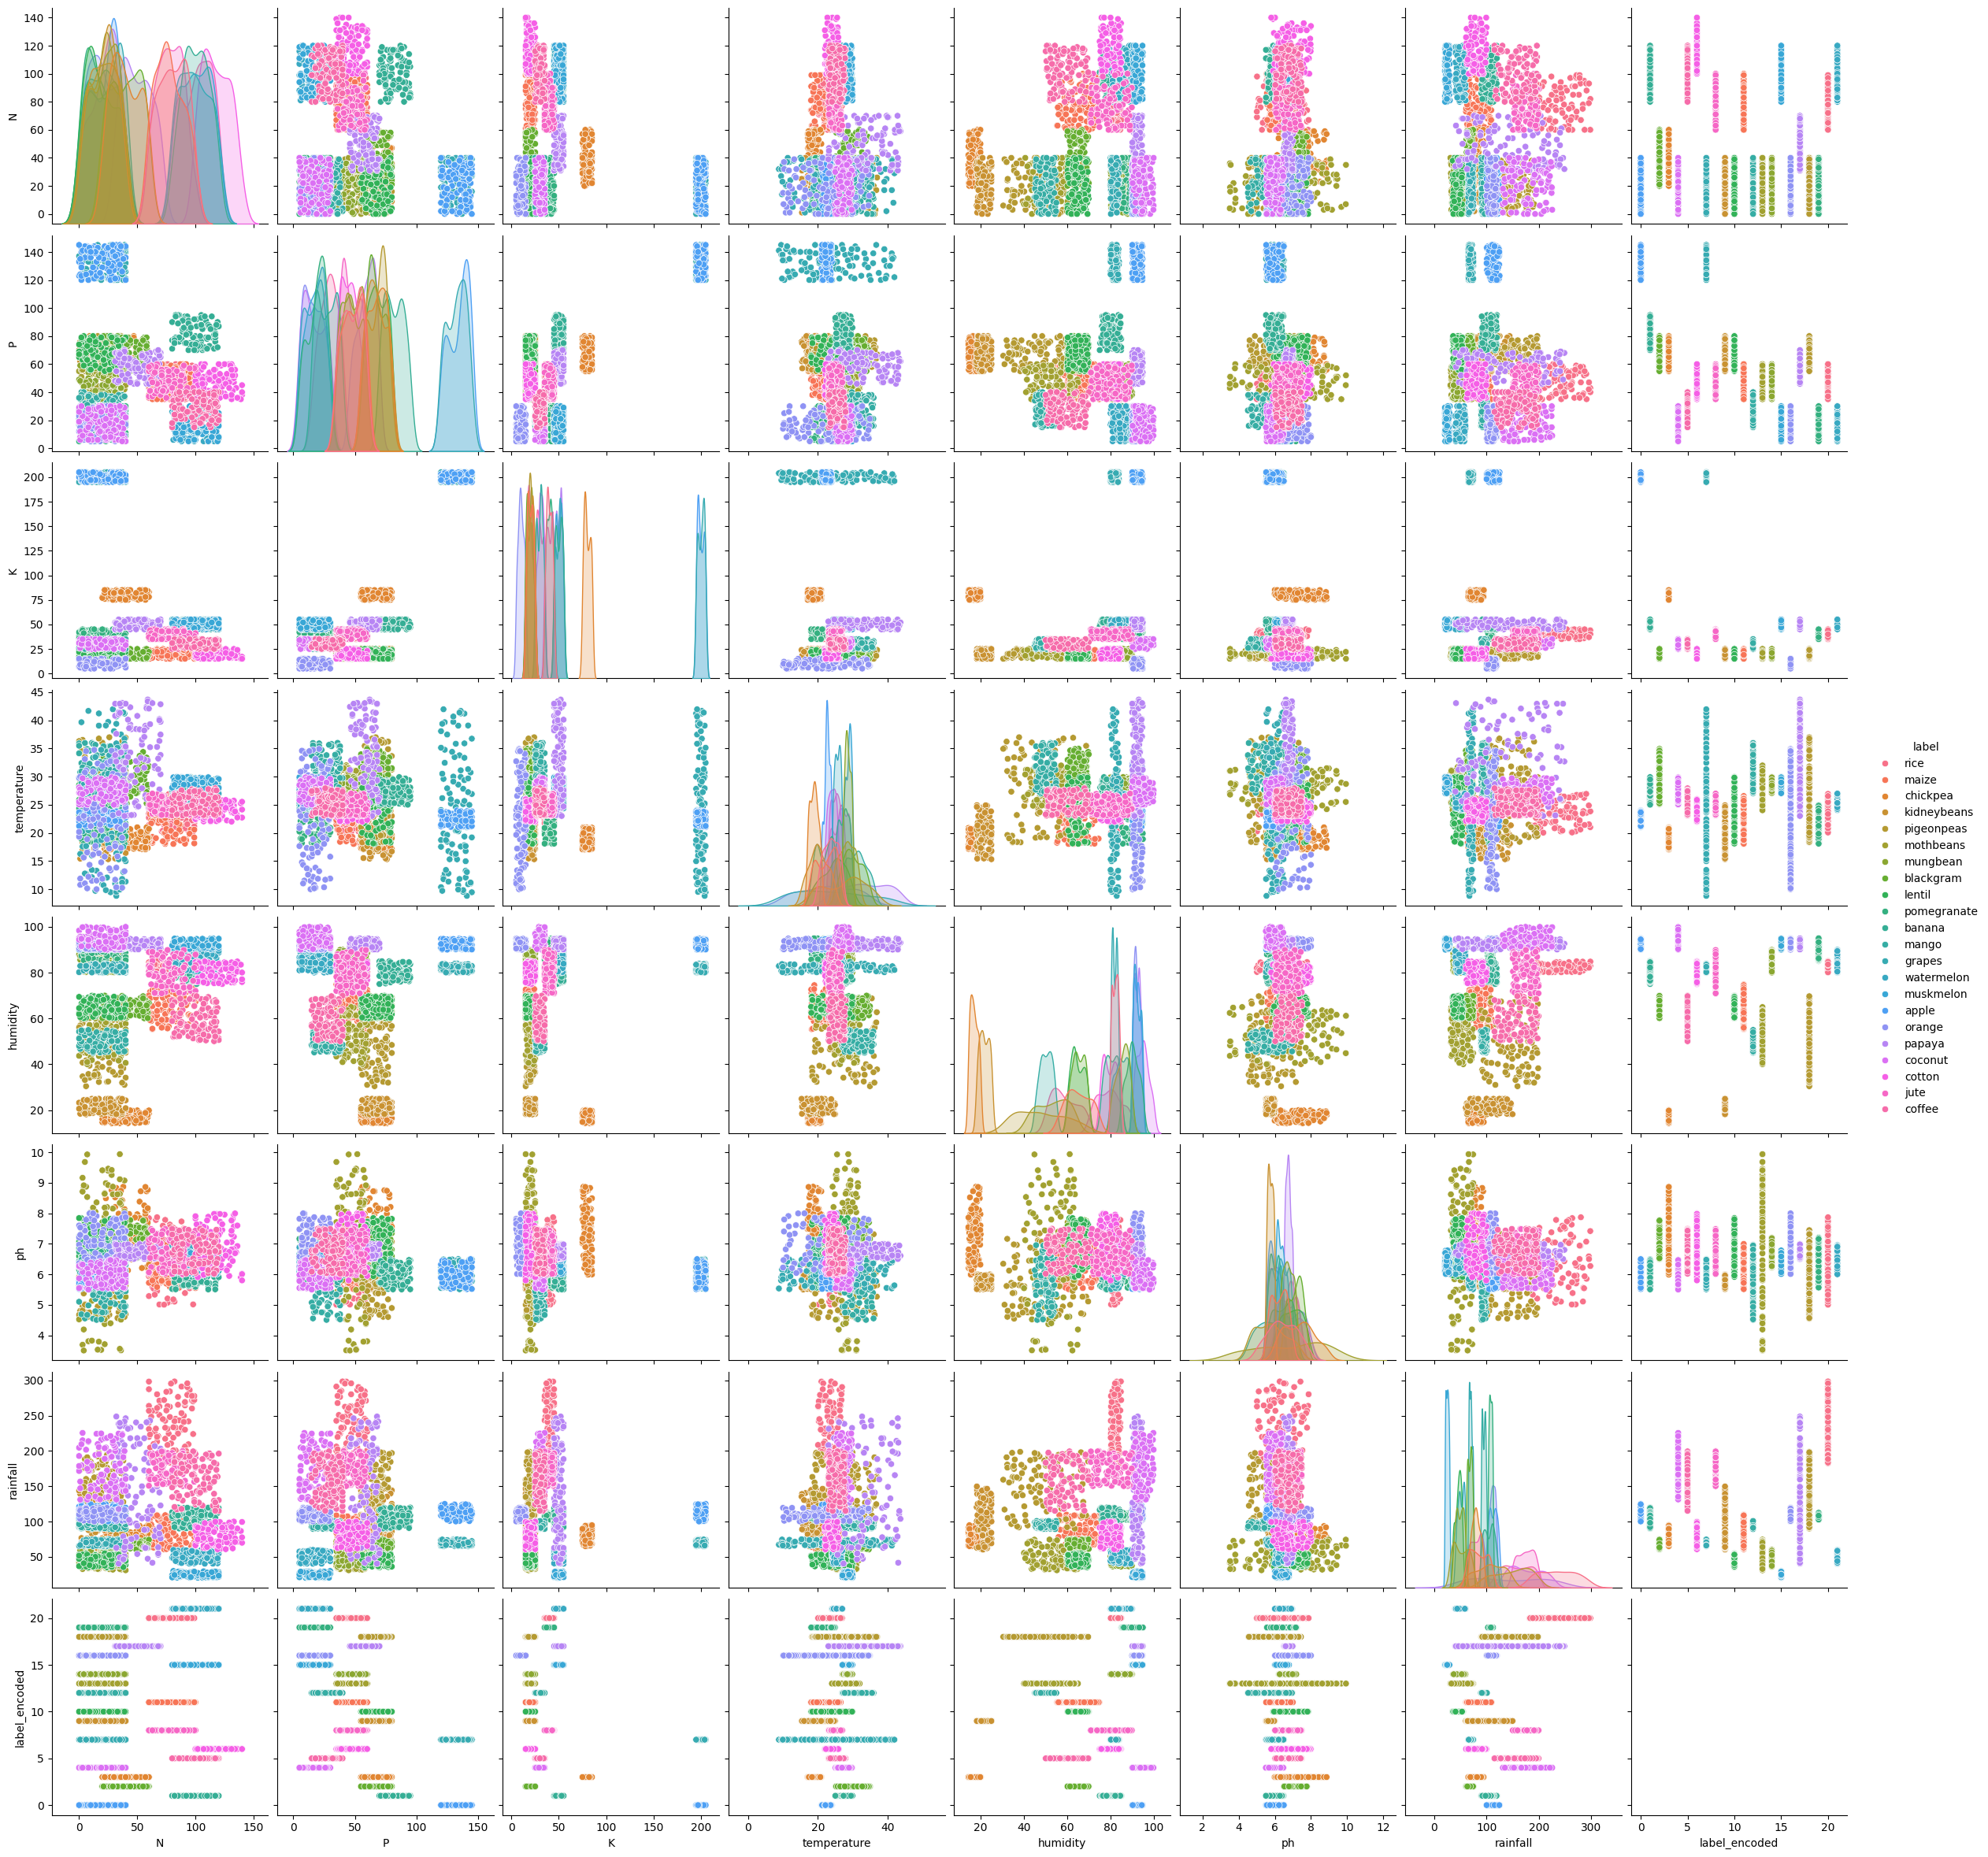

In [24]:
# Pairplot
filename = Path(os.path.join(plots_dir, "pairplot.png"))
sns.pairplot(df, hue="label", aspect=1, height=3)
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

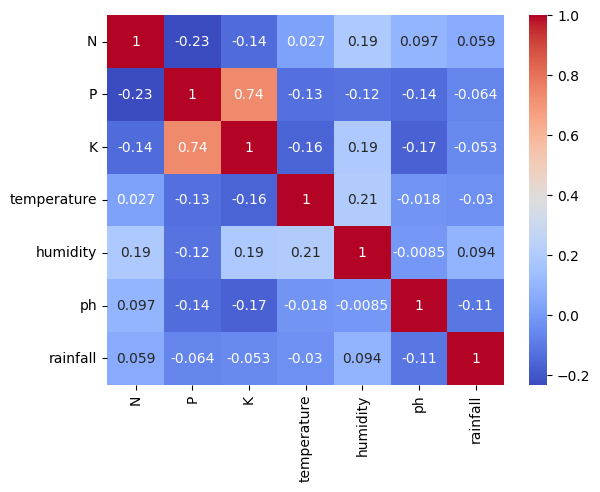

In [25]:
# Correlation Analysis
filename = Path(os.path.join(plots_dir, "heatmap.png"))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

## Model Development

In [26]:
models = {}
accuracies = {}

#### Logistic Regression

In [27]:
log_param_grid = {
    'C': uniform(0.01, 10),  # Regularization strength
    'solver': ['liblinear', 'lbfgs']  # Solver types
}

log_random_search = RandomizedSearchCV(LogisticRegression(max_iter=200), param_distributions=log_param_grid,
                                       n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
log_random_search.fit(X_train_scaled, y_train)
print(f"Best Logistic Regression Params: {log_random_search.best_params_}")
print(f"Best Logistic Regression Accuracy: {log_random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Logistic Regression Params: {'C': 8.334426408004218, 'solver': 'lbfgs'}
Best Logistic Regression Accuracy: 0.977840909090909


In [28]:
models["Logistic Regression"] = log_random_search.best_estimator_
accuracies["Logistic Regression"] = accuracy_score(y_test, models["Logistic Regression"].predict(X_test_scaled))

In [72]:
joblib.dump(log_random_search.best_estimator_, "./models/logistic_regression.joblib")

['./models/logistic_regression.joblib']

#### Decision Tree

In [29]:
tree_param_grid = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

tree_random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=tree_param_grid,
                                        n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
tree_random_search.fit(X_train_scaled, y_train)
print(f"Best Decision Tree Params: {tree_random_search.best_params_}")
print(f"Best Decision Tree Accuracy: {tree_random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Decision Tree Params: {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 8}
Best Decision Tree Accuracy: 0.9857954545454545


In [30]:
models["Decision Tree"] = tree_random_search.best_estimator_
accuracies["Decision Tree"] = accuracy_score(y_test, models["Decision Tree"].predict(X_test_scaled))

In [73]:
joblib.dump(tree_random_search.best_estimator_, "./models/decision_tree.joblib")

['./models/decision_tree.joblib']

#### Random Forest Classifier

In [31]:
rf_param_grid = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

rf_random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_param_grid,
                                      n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
rf_random_search.fit(X_train_scaled, y_train)
print(f"Best Random Forest Params: {rf_random_search.best_params_}")
print(f"Best Random Forest Accuracy: {rf_random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest Params: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 207}
Best Random Forest Accuracy: 0.9948863636363636


In [32]:
models["Random Forest"] = rf_random_search.best_estimator_
accuracies["Random Forest"] = accuracy_score(y_test, models["Random Forest"].predict(X_test_scaled))

In [75]:
joblib.dump(rf_random_search.best_estimator_, "./models/random_forest.joblib")

['./models/random_forest.joblib']

#### XGB Classifier

In [33]:
xgb_param_grid = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_random_search = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
                                       param_distributions=xgb_param_grid, n_iter=50, scoring='accuracy',
                                       cv=5, verbose=1, random_state=42)
xgb_random_search.fit(X_train_scaled, y_train)
print(f"Best XGBoost Params: {xgb_random_search.best_params_}")
print(f"Best XGBoost Accuracy: {xgb_random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Params: {'colsample_bytree': 0.7599443886861021, 'learning_rate': 0.033332831606807715, 'max_depth': 14, 'n_estimators': 257, 'subsample': 0.6931085361721216}
Best XGBoost Accuracy: 0.9948863636363636


In [34]:
models["XG Boost"] = xgb_random_search.best_estimator_
accuracies["XG Boost"] = accuracy_score(y_test, models["XG Boost"].predict(X_test_scaled))

In [76]:
joblib.dump(xgb_random_search.best_estimator_, "./models/xgb.joblib")

['./models/xgb.joblib']

#### Support Vector Classifier

In [35]:
svc_param_grid = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svc_random_search = RandomizedSearchCV(SVC(), param_distributions=svc_param_grid,
                                       n_iter=50, scoring="accuracy", cv=5, verbose=1, random_state=42)
svc_random_search.fit(X_train_scaled, y_train)
print(f"Best SVC Params: {svc_random_search.best_params_}")
print(f"Best SVC Accuracy: {svc_random_search.best_score_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best SVC Params: {'C': 1.5092422497476266, 'gamma': 'scale', 'kernel': 'linear'}
Best SVC Accuracy: 0.9875


In [36]:
models["SVC"] = svc_random_search.best_estimator_
accuracies["SVC"] = accuracy_score(y_test, models["SVC"].predict(X_test_scaled))

In [77]:
joblib.dump(svc_random_search.best_estimator_, "./models/svc.joblib")

['./models/svc.joblib']

#### Deep Learning

In [52]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [53]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', 32, 128, step=16), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', 64, 256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(y_train_categorical.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# Initialize KerasTuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='crop_recommendation'
)

Reloading Tuner from hyperparam_tuning\crop_recommendation\tuner0.json


In [56]:
# Perform hyperparameter tuning
tuner.search(X_train_scaled, y_train_categorical, epochs=50, validation_data=(X_test_scaled, y_test_categorical), batch_size=32)

In [57]:
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best Hyperparameters for Deep Learning: {best_hps.values}")
best_model = tuner.get_best_models(1)[0]

Best Hyperparameters for Deep Learning: {'units_1': 64, 'dropout_1': 0.1, 'units_2': 192, 'dropout_2': 0.5, 'learning_rate': 0.001}


In [60]:
# Train the best deep learning model
history = best_model.fit(X_train_scaled, y_train_categorical, validation_data=(X_test_scaled, y_test_categorical),
                         epochs=100, batch_size=32, verbose=1)

Epoch 1/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0303 - accuracy: 0.9892 - val_loss: 0.0222 - val_accuracy: 0.9909
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.9875 - val_loss: 0.0197 - val_accuracy: 0.9909
Epoch 3/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0284 - accuracy: 0.9903 - val_loss: 0.0205 - val_accuracy: 0.9932
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0298 - accuracy: 0.9875 - val_loss: 0.0188 - val_accuracy: 0.9955
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9903 - val_loss: 0.0184 - val_accuracy: 0.9932
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.9875 - val_loss: 0.0235 - val_accuracy: 0.9864
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9875 - val_loss: 0.0229 - val_accuracy: 0.9932
Epoch 8/100


In [64]:
# Evaluate the deep learning model
dl_eval = best_model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Best Deep Learning Accuracy: {dl_eval[1]}")

Best Deep Learning Accuracy: 0.9909090995788574


In [65]:
models["Deep Learning"] = best_model
deep_learning_predictions = np.argmax(models["Deep Learning"].predict(X_test_scaled), axis=1)

14/14 [==============================] - 0s 4ms/step


In [ ]:
best_model.save("./models/best_dl_model.h5")

In [67]:
accuracies

[0.9795454545454545,
 0.9840909090909091,
 0.9931818181818182,
 0.990909090909091,
 0.9840909090909091,
 0.990909090909091]

In [68]:
models

{'Logistic Regression': LogisticRegression(C=8.334426408004218, max_iter=200),
 'Decision Tree': DecisionTreeClassifier(max_depth=13, min_samples_split=8),
 'Random Forest': RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=13,
                        n_estimators=207),
 'XG Boost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7599443886861021, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='mlogloss', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.033332831606807715,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=14, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
     

## Model Comparision

14/14 [==============================] - 0s 3ms/step


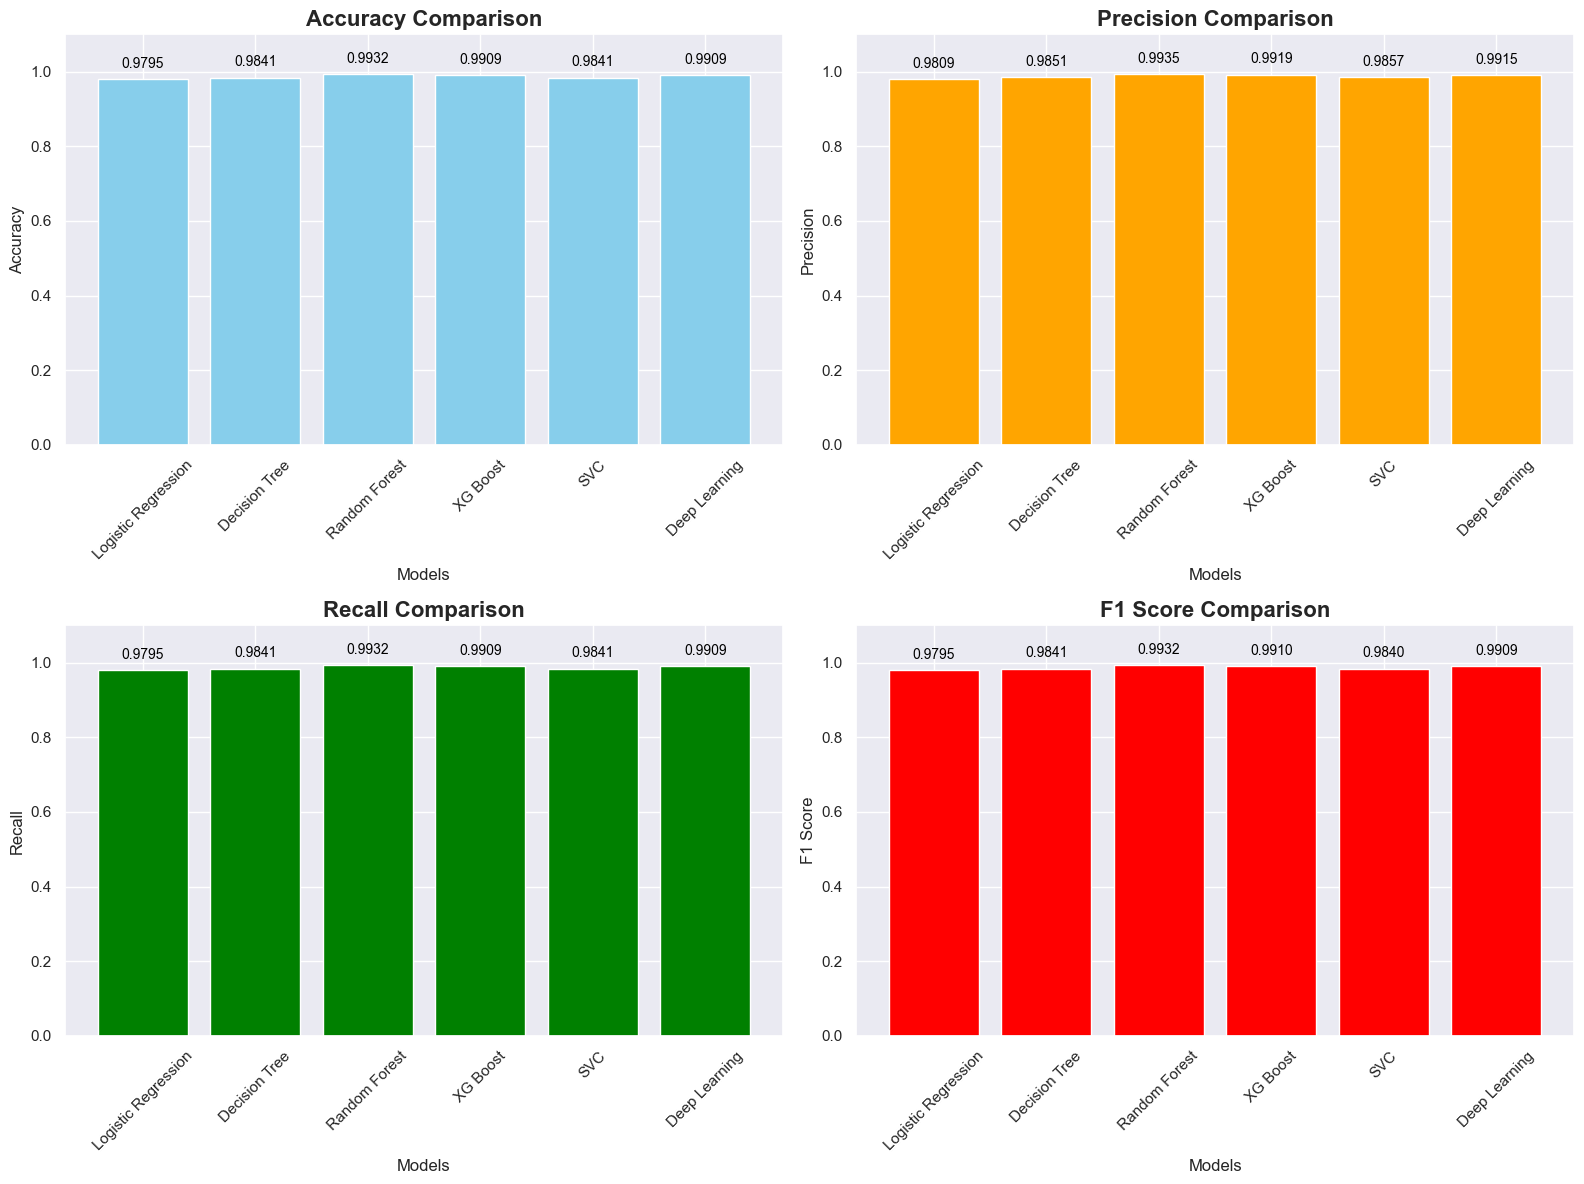

Plot saved at ./plots_dir\metrics.png


In [69]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure plots directory exists
plots_dir = "./plots_dir"
os.makedirs(plots_dir, exist_ok=True)

# Initialize dictionaries to store evaluation metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Evaluate each model
for model_name, model in models.items():
    # Deep Learning Model requires special handling
    if model_name == "Deep Learning":
        predictions = np.argmax(model.predict(X_test_scaled), axis=1)
    else:
        predictions = model.predict(X_test_scaled)
    
    accuracy_scores[model_name] = accuracy_score(y_test, predictions)
    precision_scores[model_name] = precision_score(y_test, predictions, average="weighted")
    recall_scores[model_name] = recall_score(y_test, predictions, average="weighted")
    f1_scores[model_name] = f1_score(y_test, predictions, average="weighted")

# Convert dictionaries to lists for plotting
model_names = list(models.keys())
accuracies = [accuracy_scores[model_name] for model_name in model_names]
precisions = [precision_scores[model_name] for model_name in model_names]
recalls = [recall_scores[model_name] for model_name in model_names]
f1_scores_list = [f1_scores[model_name] for model_name in model_names]

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Define metrics and corresponding data
metrics = {
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1 Score": f1_scores_list
}

colors = ['skyblue', 'orange', 'green', 'red']

# Plot each metric in a separate subplot
for ax, (metric_name, scores), color in zip(axs.flatten(), metrics.items(), colors):
    ax.bar(model_names, scores, color=color)
    ax.set_title(f"{metric_name} Comparison", fontsize=16, fontweight='bold')
    ax.set_ylim(0, 1.1)  # Ensure y-axis limits are consistent across plots
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_xlabel("Models", fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Add scores on top of the bars
    for i, score in enumerate(scores):
        ax.text(i, score + 0.03, f"{score:.4f}", ha='center', fontsize=10, color='black')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure to the plots directory
output_path = os.path.join(plots_dir, "metrics.png")
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Plot saved at {output_path}")


## Test with new data

In [85]:
scaler = joblib.load("./models/scaler_object.joblib")
model = joblib.load("./models/random_forest.joblib")
label_encoder = joblib.load("./models/label_encoder.joblib")

new_input = [92, 40, 43, 21.879744, 80.002744, 6.702985, 198.935536]
new_input_scaled = scaler.transform([new_input])
output = model.predict(new_input_scaled)
output_decoded = label_encoder.inverse_transform(output)
output_decoded[0]

'rice'